In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

hardware_name = "RTX4090"

softmax_gpu_run = pd.read_csv(
    f"results/softmax_{hardware_name}_gpu.csv", header=None, names=["M", "N", "latency", "throughput", "power", "energy", "frequency", ""]
)
softmax_gpu_run["throughput"] = (
    softmax_gpu_run["throughput"].str.extract(r"(\d+\.?\d*)").astype(float)
)
softmax_gpu_run.set_index(["M", "N"], inplace=True)

softmax_gpu_sim = pd.read_csv(
    f"results/softmax_{hardware_name}_sim.csv", header=None, names=["M", "N", "latency", "throughput", "power", "total", "memory_to_l2_transfer", "l2_to_l1_transfer", "l1_to_l0_transfer", "compute"]
)
softmax_gpu_sim["throughput"] = (
    softmax_gpu_sim["throughput"].str.extract(r"(\d+\.?\d*)").astype(float)
)
softmax_gpu_sim.set_index(["M", "N"], inplace=True)

color_NV = sns.color_palette("Greens_d", 4)[1:]

In [2]:
M = 2**12
N = 2**5
softmax_gpu_run.sort_index(inplace=True)
softmax_gpu_sim.sort_index(inplace=True)
softmax_gpu_run.loc[(M, N), "throughput"].values[0]

np.float64(10.9951)

[[np.float64(51380224.0), np.float64(102760448.0), np.float64(205520896.0), np.float64(411041792.0), np.float64(822083584.0), np.float64(1644167168.0), np.float64(3288334336.0), np.float64(6576668672.0), np.float64(13153337344.0), np.float64(26306674688.0), np.float64(52613349376.0)], [np.float64(623616.0), np.float64(623616.0), np.float64(2411315.2), np.float64(2411315.2), np.float64(9478963.2), np.float64(37583257.6), np.float64(149667840.0), np.float64(598671360.0), np.float64(2394685440.0), np.float64(19146840473.6), np.float64(153132151603.2)], [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)], [np.float64(311296.0), np.float64(625868.8), np.float64(1255014.4), np.float64(2513305.6), np.float64(5029888.0), np.float64(10063052.8), np.float64(20129382.4), np.float64(40262041.6), np.float64(80527360.0), np.float64(161057996.8), np.float64(322119270.40000004)]]


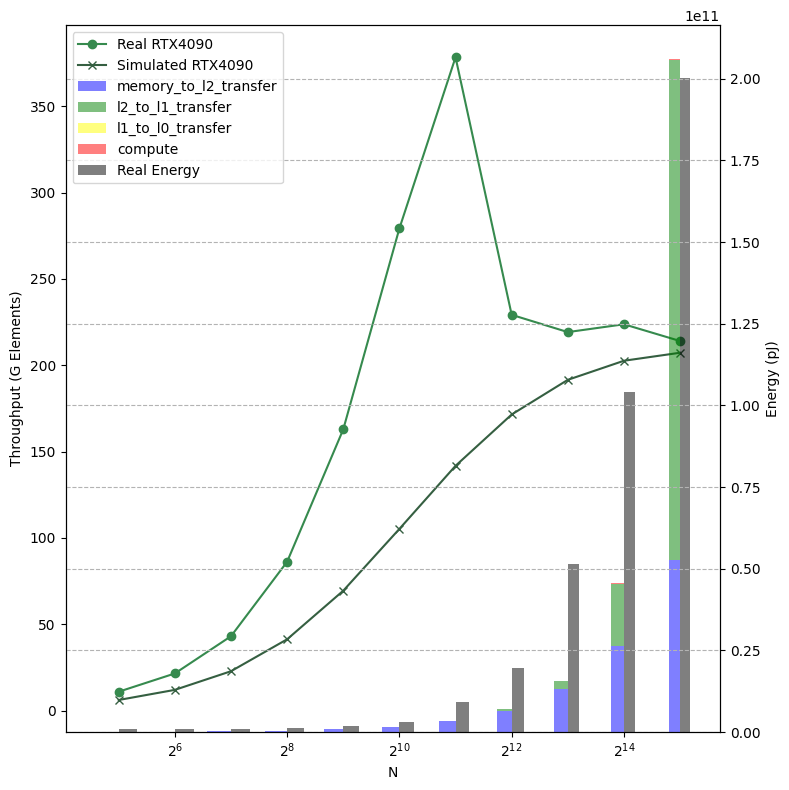

In [3]:
M = 2**12
title = f"Performance of Softmax with M={M}"
N_list = []

throughput_GPU_run_list = []
energy_GPU_run_list = []
throughput_GPU_sim_list = []
energy_GPU_sim_list = [[] for _ in range(4)]
for N in range(5, 16):
    N = 2**N
    N_list.append(N)
    throughput_GPU_run_list.append(softmax_gpu_run.loc[(M, N), "throughput"].values[0])
    energy_GPU_run_list.append(softmax_gpu_run.loc[(M, N), "energy"].values[0])
    throughput_GPU_sim_list.append(softmax_gpu_sim.loc[(M, N), "throughput"].values[0])
    energy_GPU_sim_list[0].append(softmax_gpu_sim.loc[(M, N), "memory_to_l2_transfer"].values[0])
    energy_GPU_sim_list[1].append(softmax_gpu_sim.loc[(M, N), "l2_to_l1_transfer"].values[0])
    energy_GPU_sim_list[2].append(softmax_gpu_sim.loc[(M, N), "l1_to_l0_transfer"].values[0])
    energy_GPU_sim_list[3].append(softmax_gpu_sim.loc[(M, N), "compute"].values[0])

print(energy_GPU_sim_list)

fig, ax1 = plt.subplots(figsize=(8, 8))

ax1.set_xscale("log", base=2)
ax1.set_xlabel("N")
ax1.plot(N_list, throughput_GPU_run_list, marker="o", label=f"Real {hardware_name}", color=color_NV[1])
ax1.plot(N_list, throughput_GPU_sim_list, marker="x", label=f"Simulated {hardware_name}", color=color_NV[2])
ax1.set_ylabel('Throughput (G Elements)')

ax2 = ax1.twinx()
N_list = np.array(N_list)
bar_widths = ((N_list - 2**4) * 2) / np.log2(N_list - 2**4)
ax2.bar(N_list - (bar_widths / 2), energy_GPU_sim_list[0], width=bar_widths, label='memory_to_l2_transfer', color='blue', alpha=0.5)
bottom = energy_GPU_sim_list[0]
ax2.bar(N_list - (bar_widths / 2), energy_GPU_sim_list[1], width=bar_widths, bottom=bottom, label='l2_to_l1_transfer', color='green', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[1])]
ax2.bar(N_list - (bar_widths / 2), energy_GPU_sim_list[2], width=bar_widths, bottom=bottom, label='l1_to_l0_transfer', color='yellow', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[2])]
ax2.bar(N_list - (bar_widths / 2), energy_GPU_sim_list[3], width=bar_widths, bottom=bottom, label='compute', color='red', alpha=0.5)
ax2.set_ylabel('Energy (pJ)')

ax2.bar(N_list + (bar_widths / 2), energy_GPU_run_list, width = bar_widths, label='Real Energy', color='black', alpha=0.5)

ax2.plot([], [], marker="o", label=f"Real {hardware_name}", color=color_NV[1])
ax2.plot([], [], marker="x", label=f"Simulated {hardware_name}", color=color_NV[2])

ax2.legend(loc='upper left')

plt.grid(True, which="both", ls="--", c="0.7")  # Adding a grid for better readability
plt.tight_layout()
plt.show()


[[np.float64(51380224.0), np.float64(102760448.0), np.float64(205520896.0), np.float64(411041792.0), np.float64(822083584.0), np.float64(1644167168.0), np.float64(3288334336.0), np.float64(6576668672.0), np.float64(13153337344.0), np.float64(26306674688.0), np.float64(52613349376.0)], [np.float64(9478963.2), np.float64(149667840.0), np.float64(598671360.0), np.float64(598671360.0), np.float64(598671360.0), np.float64(598671360.0), np.float64(598671360.0), np.float64(598671360.0), np.float64(598671360.0), np.float64(1197342720.0), np.float64(2394685440.0)], [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)], [np.float64(314547.2), np.float64(629094.4), np.float64(1258188.8), np.float64(2516377.6), np.float64(5032755.2), np.float64(10065510.4), np.float64(20131020.8), np.float64(40262041.6), np.float64(80524083.2), np.float64(161048166.4), np.float64(322096332.8)]]


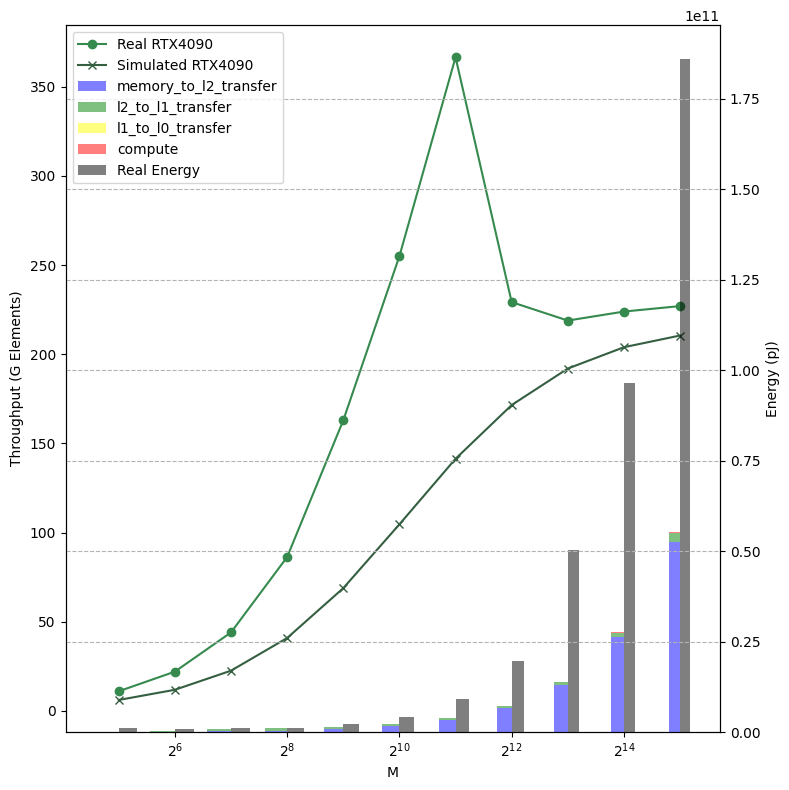

In [4]:
N= 2**12
title = f"Performance of Softmax with M={M}"
N_list = []

throughput_GPU_run_list = []
energy_GPU_run_list = []
throughput_GPU_sim_list = []
energy_GPU_sim_list = [[] for _ in range(4)]
for M in range(5, 16):
    M = 2**M
    N_list.append(M)
    throughput_GPU_run_list.append(softmax_gpu_run.loc[(M, N), "throughput"].iloc[0])
    energy_GPU_run_list.append(softmax_gpu_run.loc[(M, N), "energy"].iloc[0])
    throughput_GPU_sim_list.append(softmax_gpu_sim.loc[(M, N), "throughput"].iloc[0])
    energy_GPU_sim_list[0].append(softmax_gpu_sim.loc[(M, N), "memory_to_l2_transfer"].iloc[0])
    energy_GPU_sim_list[1].append(softmax_gpu_sim.loc[(M, N), "l2_to_l1_transfer"].iloc[0])
    energy_GPU_sim_list[2].append(softmax_gpu_sim.loc[(M, N), "l1_to_l0_transfer"].iloc[0])
    energy_GPU_sim_list[3].append(softmax_gpu_sim.loc[(M, N), "compute"].iloc[0])

print(energy_GPU_sim_list)

fig, ax1 = plt.subplots(figsize=(8, 8))

ax1.set_xscale("log", base=2)
ax1.set_xlabel("M")
ax1.plot(N_list, throughput_GPU_run_list, marker="o", label=f"Real {hardware_name}", color=color_NV[1])
ax1.plot(N_list, throughput_GPU_sim_list, marker="x", label=f"Simulated {hardware_name}", color=color_NV[2])
ax1.set_ylabel('Throughput (G Elements)')

ax2 = ax1.twinx()
N_list = np.array(N_list)
bar_widths = ((N_list - 2**4) * 2) / np.log2(N_list - 2**4)
ax2.bar(N_list - (bar_widths / 2), energy_GPU_sim_list[0], width=bar_widths, label='memory_to_l2_transfer', color='blue', alpha=0.5)
bottom = energy_GPU_sim_list[0]
ax2.bar(N_list - (bar_widths / 2), energy_GPU_sim_list[1], width=bar_widths, bottom=bottom, label='l2_to_l1_transfer', color='green', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[1])]
ax2.bar(N_list - (bar_widths / 2), energy_GPU_sim_list[2], width=bar_widths, bottom=bottom, label='l1_to_l0_transfer', color='yellow', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[2])]
ax2.bar(N_list - (bar_widths / 2), energy_GPU_sim_list[3], width=bar_widths, bottom=bottom, label='compute', color='red', alpha=0.5)
ax2.set_ylabel('Energy (pJ)')

ax2.bar(N_list + (bar_widths / 2), energy_GPU_run_list, width = bar_widths, label='Real Energy', color='black', alpha=0.5)

ax2.plot([], [], marker="o", label=f"Real {hardware_name}", color=color_NV[1])
ax2.plot([], [], marker="x", label=f"Simulated {hardware_name}", color=color_NV[2])

ax2.legend(loc='upper left')

plt.grid(True, which="both", ls="--", c="0.7")  # Adding a grid for better readability
plt.tight_layout()
plt.show()